* Volume Preprocessing both monthly and weekly
* data prep for clustering
* data prep for delisting

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
# import jupyter_black

# jupyter_black.load()

In [3]:
import os

os.chdir(
    r"/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
from pandarallel import pandarallel
import re
from datetime import datetime
import gc
from sklearn.preprocessing import FunctionTransformer
# from helpers.compress import reduce_mem_usage
import pickle
import warnings

warnings.filterwarnings("ignore")

In [5]:
pandarallel.initialize(progress_bar=True, nb_workers=os.cpu_count() - 2)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
data_folder = "data"
processed_data_folder = "processed_data_S2"

##### Analysis

In [7]:
volume_df = pd.read_csv(f"{data_folder}/hackathon_training_data_csv_file.csv")

In [8]:
volume_df = volume_df.drop(["Unnamed: 0"], axis=1)
volume_df.isnull().sum()

year                 0
month                0
day                  0
sales_volume_hl      0
ppg_name             0
unique_poc_id      130
dtype: int64

In [9]:
volume_df.shape

(39825098, 6)

In [10]:
def basic_preprocessing(df):
    # removing nulls
#     df = df.loc[
#         (df["unique_poc_id"].notnull()) & (df["ppg_name"].notnull())
#     ].reset_index(drop=True)

    df['unique_poc_id'] = df["unique_poc_id"].fillna("NA1")
    # clean name
    df["ppg_name_clean"] = df["ppg_name"].parallel_apply(
        lambda x: re.sub(r"\s+", "_", x)
    )
    # poc-Ppg id
    df["poc_ppg_id"] = df.parallel_apply(
        lambda x: str(x["unique_poc_id"]) + "__" + str(x["ppg_name_clean"]), axis=1
    )

    # date column
    df["date"] = pd.to_datetime(df[["year", "month", "day"]])

    df = (
        df.groupby(["poc_ppg_id", "date", "ppg_name", "unique_poc_id"])
        .agg(sales_volume_hl=("sales_volume_hl", "mean"))
        .reset_index()
    )
    df["sales_volume_hl"] = df["sales_volume_hl"].clip(lower=0.0)

    return df

In [11]:
volume_df = basic_preprocessing(volume_df)

In [12]:
volume_df.head()

,poc_ppg_id,date,ppg_name,unique_poc_id,sales_volume_hl
0,AAAA__AK_AB_CG_T,2019-04-20,AK AB CG T,AAAA,0.065803
1,AAAA__AK_AB_CG_T,2019-05-25,AK AB CG T,AAAA,0.131605
2,AAAA__AK_CW_FM_CG_T,2020-06-13,AK CW FM CG T,AAAA,0.098704
3,AAAA__AR_EW_N_DS_CG_T,2019-02-11,AR EW N DS CG T,AAAA,0.000000
4,AAAA__AR_EW_N_DS_CG_T,2019-02-15,AR EW N DS CG T,AAAA,0.164507


In [13]:
# volume_df = reduce_mem_usage(volume_df)
print(volume_df.shape)
print(volume_df.isnull().sum())

(39779370, 5)
poc_ppg_id         0
date               0
ppg_name           0
unique_poc_id      0
sales_volume_hl    0
dtype: int64


In [14]:
np.percentile(volume_df["sales_volume_hl"], 2)

0.0

##### calendar

In [15]:
holidays_df = pd.read_csv(
    os.path.join(data_folder, "South_Africa_Holidays_2019_2022.csv")
)

calendar_df = pd.read_csv(
    os.path.join(data_folder, "Calendar_skeleton.csv")
)

def sin_transformer(period):
    return lambda x: np.sin(x / period * 2 * np.pi)


def cos_transformer(period):
    return lambda x: np.cos(x / period * 2 * np.pi)

In [16]:
calendar_df.head()

,date,year,month,week,adjusted_year,adjusted_month,year_week_start_date
0,1/1/2019,2019,1,1,2019,1,1/1/2019
1,1/2/2019,2019,1,1,2019,1,1/1/2019
2,1/3/2019,2019,1,1,2019,1,1/1/2019
3,1/4/2019,2019,1,1,2019,1,1/1/2019
4,1/5/2019,2019,1,1,2019,1,1/1/2019


In [17]:
def get_calendar_df(holidays_df, calendar_df):
    # holidays df
    holidays_df["Date"] = pd.to_datetime(holidays_df["Date"])
    holidays_df.columns = [col.lower() for col in holidays_df.columns]

    # calendar at daily from date1 to date2
    calendar_df['date'] = pd.to_datetime(calendar_df['date'], format="%m/%d/%Y")
    calendar_df['year_week_start_date'] = pd.to_datetime(calendar_df['year_week_start_date'], format="%m/%d/%Y")

    # features
    calendar_df["day_of_the_week"] = calendar_df["date"].dt.dayofweek
    # 0-Monday and so on
    calendar_df["is_weekend"] = calendar_df["date"].dt.dayofweek // 4
    calendar_df["is_month_start"] = calendar_df["date"].dt.is_month_start.astype(int)
    calendar_df["is_month_end"] = calendar_df["date"].dt.is_month_end.astype(int)
    calendar_df["quarter"] = calendar_df["date"].dt.quarter

    calendar_df["key"] = 1  # key for merging with unique combinations of id

    # merging the calendar records
    calendar_df = pd.merge(
        calendar_df, holidays_df[["date", "holiday"]], how="left", on="date"
    )

    # holiday marker
    calendar_df["holiday"] = calendar_df["holiday"].parallel_apply(
        lambda x: 1 if not pd.isnull(x) else 0.0
    )
    
    # cyclical
    calendar_df["month_sin_adj"] = calendar_df["adjusted_month"].apply(sin_transformer(12))
    calendar_df["month_cos_adj"] = calendar_df["adjusted_month"].apply(cos_transformer(12))
    
    calendar_df["month_sin"] = calendar_df["month"].apply(sin_transformer(12))
    calendar_df["month_cos"] = calendar_df["month"].apply(cos_transformer(12))

    calendar_df["week_sin"] = calendar_df["week"].apply(sin_transformer(52))
    calendar_df["week_cos"] = calendar_df["week"].apply(cos_transformer(52))

    calendar_df["quarter_sin"] = calendar_df["quarter"].apply(sin_transformer(4))
    calendar_df["quarter_cos"] = calendar_df["quarter"].apply(cos_transformer(4))

    # month start date
    calendar_df["year_month_start_date"] = calendar_df.groupby(
        ["year", "month"]
    )["date"].transform(lambda x: x.min())

    return calendar_df

In [18]:
calendar_df = get_calendar_df(holidays_df,calendar_df)

In [19]:
print(calendar_df.shape)
print(calendar_df.isnull().sum())
calendar_df.head()

(1826, 23)
date                     0
year                     0
month                    0
week                     0
adjusted_year            0
adjusted_month           0
year_week_start_date     0
day_of_the_week          0
is_weekend               0
is_month_start           0
is_month_end             0
quarter                  0
key                      0
holiday                  0
month_sin_adj            0
month_cos_adj            0
month_sin                0
month_cos                0
week_sin                 0
week_cos                 0
quarter_sin              0
quarter_cos              0
year_month_start_date    0
dtype: int64


,date,year,month,week,adjusted_year,adjusted_month,year_week_start_date,day_of_the_week,is_weekend,is_month_start,is_month_end,quarter,key,holiday,month_sin_adj,month_cos_adj,month_sin,month_cos,week_sin,week_cos,quarter_sin,quarter_cos,year_month_start_date
0,2019-01-01,2019,1,1,2019,1,2019-01-01,1,0,1,0,1,1,1.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
1,2019-01-02,2019,1,1,2019,1,2019-01-01,2,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
2,2019-01-03,2019,1,1,2019,1,2019-01-01,3,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
3,2019-01-04,2019,1,1,2019,1,2019-01-01,4,1,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
4,2019-01-05,2019,1,1,2019,1,2019-01-01,5,1,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01


#### Next todos
- get the year week information in volume data from calendar
- get store level sales information with contribution yoy and start_date and last_date
- get ppg level sales information with contribution yoy and start_date and last_date
- get id level information for start of sales and last sales and derivatives
- aggregate the data at weekly level for all ids combined
- then we take a call of which sku to delist and which ppg ones
- Make the volume continous at weekly/monthly level



In [20]:
volume_df.head()

,poc_ppg_id,date,ppg_name,unique_poc_id,sales_volume_hl
0,AAAA__AK_AB_CG_T,2019-04-20,AK AB CG T,AAAA,0.065803
1,AAAA__AK_AB_CG_T,2019-05-25,AK AB CG T,AAAA,0.131605
2,AAAA__AK_CW_FM_CG_T,2020-06-13,AK CW FM CG T,AAAA,0.098704
3,AAAA__AR_EW_N_DS_CG_T,2019-02-11,AR EW N DS CG T,AAAA,0.000000
4,AAAA__AR_EW_N_DS_CG_T,2019-02-15,AR EW N DS CG T,AAAA,0.164507


In [21]:
calendar_df.head(3)

,date,year,month,week,adjusted_year,adjusted_month,year_week_start_date,day_of_the_week,is_weekend,is_month_start,is_month_end,quarter,key,holiday,month_sin_adj,month_cos_adj,month_sin,month_cos,week_sin,week_cos,quarter_sin,quarter_cos,year_month_start_date
0,2019-01-01,2019,1,1,2019,1,2019-01-01,1,0,1,0,1,1,1.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
1,2019-01-02,2019,1,1,2019,1,2019-01-01,2,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
2,2019-01-03,2019,1,1,2019,1,2019-01-01,3,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01


In [22]:
volume_df = pd.merge(
    volume_df,
    calendar_df[["date", "adjusted_year", "adjusted_month", "week",'year',"month"]],
    how="left",
    on="date",
)

In [23]:
volume_df.head()

,poc_ppg_id,date,ppg_name,unique_poc_id,sales_volume_hl,adjusted_year,adjusted_month,week,year,month
0,AAAA__AK_AB_CG_T,2019-04-20,AK AB CG T,AAAA,0.065803,2019,4,16,2019,4
1,AAAA__AK_AB_CG_T,2019-05-25,AK AB CG T,AAAA,0.131605,2019,5,21,2019,5
2,AAAA__AK_CW_FM_CG_T,2020-06-13,AK CW FM CG T,AAAA,0.098704,2020,6,24,2020,6
3,AAAA__AR_EW_N_DS_CG_T,2019-02-11,AR EW N DS CG T,AAAA,0.000000,2019,2,7,2019,2
4,AAAA__AR_EW_N_DS_CG_T,2019-02-15,AR EW N DS CG T,AAAA,0.164507,2019,2,7,2019,2


In [24]:
print(volume_df.isnull().sum())

poc_ppg_id         0
date               0
ppg_name           0
unique_poc_id      0
sales_volume_hl    0
adjusted_year      0
adjusted_month     0
week               0
year               0
month              0
dtype: int64


##### id-store-ppg dates

In [25]:
max_date = volume_df["date"].dt.date.max()

In [26]:
def id_stores_ppg_datesdf(df, calendar_df, max_date):

    # id wise min max dates
    id_life_df = df.groupby(
        ["poc_ppg_id", "unique_poc_id", "ppg_name"], as_index=False
    ).agg(
        start_date_vol=("date", "min"),
        end_date_vol=("date", "max"),
        unique_selling_days=("date", "count"),
    )

    id_life_df = pd.merge(
        id_life_df,
        calendar_df[["year_week_start_date", "year_month_start_date", "date"]],
        left_on="start_date_vol",
        right_on="date",
    )

    # life of the id
    id_life_df["life_from_start_months"] = (
        max_date.year - id_life_df["start_date_vol"].dt.year
    ) * 12 + (max_date.month - id_life_df["start_date_vol"].dt.month)

    # last when sold id
    id_life_df["last_selling_record_months"] = (
        max_date.year - id_life_df["end_date_vol"].dt.year
    ) * 12 + (max_date.month - id_life_df["end_date_vol"].dt.month)

    id_life_df["inactive_life"] = round(
        id_life_df["last_selling_record_months"] / id_life_df["life_from_start_months"],
        2,
    ).fillna(0.0)

    # store last recorded date
    id_life_df["poc_last_sell_date"] = id_life_df.groupby(["unique_poc_id"])[
        "end_date_vol"
    ].transform(lambda x: x.max())

    # ppg last recorded date
    id_life_df["ppg_last_sell_date"] = id_life_df.groupby(["ppg_name"])[
        "end_date_vol"
    ].transform(lambda x: x.max())

    # store gap from current
    id_life_df["poc_last_sell_months"] = (
        max_date.year - id_life_df["poc_last_sell_date"].dt.year
    ) * 12 + (max_date.month - id_life_df["poc_last_sell_date"].dt.month)

    # ppg gap from current
    id_life_df["ppg_last_sell_months"] = (
        max_date.year - id_life_df["ppg_last_sell_date"].dt.year
    ) * 12 + (max_date.month - id_life_df["ppg_last_sell_date"].dt.month)

    # col re-name
    id_life_df = id_life_df.rename(
        columns={
            "year_week_start_date": "year_week_start_date_id",
            "year_month_start_date": "year_month_start_date_id",
        }
    )

    return id_life_df

In [27]:
id_life_df = id_stores_ppg_datesdf(volume_df, calendar_df, max_date)

In [28]:
# id_life_df = reduce_mem_usage(id_life_df)

In [29]:
# id_life_df.loc[id_life_df['inactive_life'].isnull()].head()

In [30]:
id_life_df.isnull().sum()

poc_ppg_id                    0
unique_poc_id                 0
ppg_name                      0
start_date_vol                0
end_date_vol                  0
unique_selling_days           0
year_week_start_date_id       0
year_month_start_date_id      0
date                          0
life_from_start_months        0
last_selling_record_months    0
inactive_life                 0
poc_last_sell_date            0
ppg_last_sell_date            0
poc_last_sell_months          0
ppg_last_sell_months          0
dtype: int64

In [31]:
id_life_df.head()

,poc_ppg_id,unique_poc_id,ppg_name,start_date_vol,end_date_vol,unique_selling_days,year_week_start_date_id,year_month_start_date_id,date,life_from_start_months,last_selling_record_months,inactive_life,poc_last_sell_date,ppg_last_sell_date,poc_last_sell_months,ppg_last_sell_months
0,AAAA__AK_AB_CG_T,AAAA,AK AB CG T,2019-04-20,2019-05-25,2,2019-04-15,2019-04-01,2019-04-20,44,43,0.98,2020-06-13,2022-12-31,30,0
1,AAAA__CJ_CZ_CG_EH,AAAA,CJ CZ CG EH,2019-04-20,2019-07-24,2,2019-04-15,2019-04-01,2019-04-20,44,41,0.93,2020-06-13,2022-12-31,30,0
2,AAAA__CM_CG_T,AAAA,CM CG T,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2020-06-13,2022-11-30,30,1
3,AACL__CJ_CZ_ES_ER,AACL,CJ CZ ES ER,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2022-12-24,2022-12-31,0,0
4,AACL__CJ_C_ES_ER,AACL,CJ C ES ER,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2022-12-24,2022-12-31,0,0


In [32]:
poc_life_df = id_life_df.groupby(["unique_poc_id"], as_index=False).parallel_apply(
    lambda x: (x["end_date_vol"].max() - x["start_date_vol"].min())
    / np.timedelta64(1, "M")
)

In [33]:
poc_life_df.columns = ["unique_poc_id", "poc_life"]

In [34]:
poc_life_df.head()

,unique_poc_id,poc_life
0,AA,45.241175
1,AAA,47.902421
2,AAAA,16.657426
3,AAAC,47.639582
4,AAAD,47.836711


In [35]:
ppg_life_df = id_life_df.groupby(["ppg_name"], as_index=False).parallel_apply(
    lambda x: (x["end_date_vol"].max() - x["start_date_vol"].min())
    / np.timedelta64(1, "M")
)

In [36]:
ppg_life_df.columns = ["ppg_name", "ppg_life"]

In [37]:
ppg_life_df.head()

,ppg_name,ppg_life
0,AG FC EN CK,47.902421
1,AG FC ES DX,47.935276
2,AK AB CG T,47.968131
3,AK AB ES AN,47.376743
4,AK AB FN DY,46.949629


In [38]:
# merge back

In [39]:
id_life_df = pd.merge(id_life_df, poc_life_df, how="left", on="unique_poc_id")
id_life_df = pd.merge(id_life_df, ppg_life_df, how="left", on="ppg_name")

In [40]:
id_life_df.head()

,poc_ppg_id,unique_poc_id,ppg_name,start_date_vol,end_date_vol,unique_selling_days,year_week_start_date_id,year_month_start_date_id,date,life_from_start_months,last_selling_record_months,inactive_life,poc_last_sell_date,ppg_last_sell_date,poc_last_sell_months,ppg_last_sell_months,poc_life,ppg_life
0,AAAA__AK_AB_CG_T,AAAA,AK AB CG T,2019-04-20,2019-05-25,2,2019-04-15,2019-04-01,2019-04-20,44,43,0.98,2020-06-13,2022-12-31,30,0,16.657426,47.968131
1,AAAA__CJ_CZ_CG_EH,AAAA,CJ CZ CG EH,2019-04-20,2019-07-24,2,2019-04-15,2019-04-01,2019-04-20,44,41,0.93,2020-06-13,2022-12-31,30,0,16.657426,47.968131
2,AAAA__CM_CG_T,AAAA,CM CG T,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2020-06-13,2022-11-30,30,1,16.657426,46.949629
3,AACL__CJ_CZ_ES_ER,AACL,CJ CZ ES ER,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2022-12-24,2022-12-31,0,0,45.372595,47.968131
4,AACL__CJ_C_ES_ER,AACL,CJ C ES ER,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2022-12-24,2022-12-31,0,0,45.372595,47.968131


In [41]:
id_life_df.isnull().sum()

poc_ppg_id                    0
unique_poc_id                 0
ppg_name                      0
start_date_vol                0
end_date_vol                  0
unique_selling_days           0
year_week_start_date_id       0
year_month_start_date_id      0
date                          0
life_from_start_months        0
last_selling_record_months    0
inactive_life                 0
poc_last_sell_date            0
ppg_last_sell_date            0
poc_last_sell_months          0
ppg_last_sell_months          0
poc_life                      0
ppg_life                      0
dtype: int64

###### store level analysis

In [42]:
store_yoy_df = volume_df.groupby(
    ["unique_poc_id", "adjusted_year"], as_index=False
).agg(agg_sales_stores=("sales_volume_hl", "sum"), agg_sales_record=("date", "count"))

# weighted
store_yoy_df["agg_sales_stores"] = (
    store_yoy_df["agg_sales_stores"] / store_yoy_df["agg_sales_record"]
)

# rank by year
store_yoy_df["store_rank"] = store_yoy_df.groupby(["adjusted_year"])[
    "agg_sales_stores"
].transform(lambda x: x.rank(method="dense", ascending=False))

# pct changes by store
store_yoy_df["store_pct_changes"] = store_yoy_df.groupby(["unique_poc_id"])[
    "agg_sales_stores"
].transform(lambda x: x.pct_change())

# store_yoy_df.sort_values(["adjusted_year", "store_rank"], ascending=[True, True]).head(
#     50
# )

# Pivot the DataFrame to get the desired format
store_yoy_pivot_df = store_yoy_df.pivot_table(
    index="unique_poc_id",
    columns="adjusted_year",
    values=["agg_sales_stores", "store_rank", "store_pct_changes"],
    aggfunc="first",
)

# Flatten the MultiIndex columns
store_yoy_pivot_df.columns = [
    f"{year}_{metric}" for metric, year in store_yoy_pivot_df.columns
]

# Reset the index to turn 'unique_poc_id' back into a column
store_yoy_pivot_df = store_yoy_pivot_df.reset_index()

In [43]:
store_yoy_pivot_df.head()

,unique_poc_id,2019_agg_sales_stores,2020_agg_sales_stores,2021_agg_sales_stores,2022_agg_sales_stores,2020_store_pct_changes,2021_store_pct_changes,2022_store_pct_changes,2019_store_rank,2020_store_rank,2021_store_rank,2022_store_rank
0,AA,0.068596,0.128300,0.111659,0.084263,0.870388,-0.129709,-0.245348,33389.0,29891.0,30825.0,30798.0
1,AAA,1.274841,4.055424,7.613236,3.550105,2.181121,0.877297,-0.533693,3021.0,1120.0,651.0,1622.0
2,AAAA,0.143902,0.184197,NaN,NaN,0.280023,NaN,NaN,27908.0,25765.0,NaN,NaN
3,AAAC,0.384567,0.350626,0.432555,0.579081,-0.088258,0.233663,0.338747,12113.0,15670.0,14179.0,11091.0
4,AAAD,0.413035,0.321357,0.465599,0.450399,-0.221961,0.448851,-0.032645,11177.0,17022.0,13156.0,14208.0


In [44]:
sales_cols = store_yoy_pivot_df.filter(regex="sales_stores").columns.tolist()
rank_cols = store_yoy_pivot_df.filter(regex="store_rank").columns.tolist()
pct_changes_cols = store_yoy_pivot_df.filter(regex="store_pct_changes").columns.tolist()

store_yoy_pivot_df[sales_cols] = store_yoy_pivot_df[sales_cols].fillna(0.0)
store_yoy_pivot_df[pct_changes_cols] = store_yoy_pivot_df[pct_changes_cols].fillna(0.0)
store_yoy_pivot_df[rank_cols] = store_yoy_pivot_df[rank_cols].fillna(
    len(store_yoy_pivot_df) + 1
)

In [45]:
store_yoy_pivot_df["median_rank"] = store_yoy_pivot_df[rank_cols].median(axis=1)

store_yoy_pivot_df = store_yoy_pivot_df.sort_values(
    ["median_rank"], ascending=True
).reset_index(drop=True)

In [46]:
def classify_tier(rank, df):
    if rank <= np.percentile(df["median_rank"], 20):
        return "Top"
    elif rank <= np.percentile(df["median_rank"], 50):
        return "Middle"
    else:
        return "Bottom"

In [47]:
# Apply the classification function to create a tier column
store_yoy_pivot_df["class_tier"] = store_yoy_pivot_df["median_rank"].parallel_apply(
    lambda x: classify_tier(x, store_yoy_pivot_df)
)

In [48]:
store_yoy_pivot_df.isnull().sum()

unique_poc_id             0
2019_agg_sales_stores     0
2020_agg_sales_stores     0
2021_agg_sales_stores     0
2022_agg_sales_stores     0
2020_store_pct_changes    0
2021_store_pct_changes    0
2022_store_pct_changes    0
2019_store_rank           0
2020_store_rank           0
2021_store_rank           0
2022_store_rank           0
median_rank               0
class_tier                0
dtype: int64

In [49]:
# getting information of last sales
store_last_sold = id_life_df.drop_duplicates(["unique_poc_id"])[
    ["unique_poc_id", "poc_last_sell_months", "poc_life"]
].reset_index(drop=True)

In [50]:
store_yoy_pivot_df = pd.merge(
    store_yoy_pivot_df, store_last_sold, how="left", on="unique_poc_id"
)

In [51]:
# store_yoy_pivot_df = reduce_mem_usage(store_yoy_pivot_df)

In [52]:
store_yoy_pivot_df.isnull().sum()

unique_poc_id             0
2019_agg_sales_stores     0
2020_agg_sales_stores     0
2021_agg_sales_stores     0
2022_agg_sales_stores     0
2020_store_pct_changes    0
2021_store_pct_changes    0
2022_store_pct_changes    0
2019_store_rank           0
2020_store_rank           0
2021_store_rank           0
2022_store_rank           0
median_rank               0
class_tier                0
poc_last_sell_months      0
poc_life                  0
dtype: int64

<Axes: >

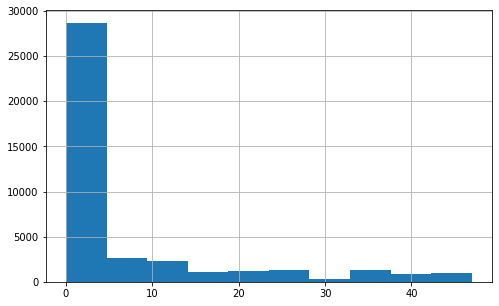

In [53]:
plt.figure(figsize=(8, 5))
store_yoy_pivot_df["poc_last_sell_months"].hist()

<Axes: >

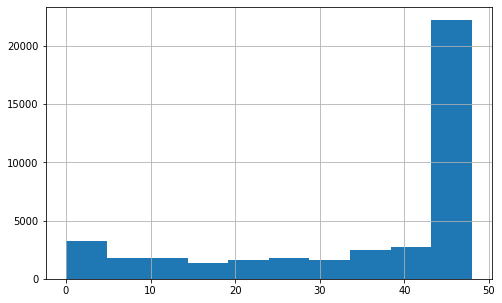

In [54]:
plt.figure(figsize=(8, 5))
store_yoy_pivot_df["poc_life"].hist()

##### ppg level analysis

In [55]:
ppg_yoy_df = volume_df.groupby(["ppg_name", "adjusted_year"], as_index=False).agg(
    agg_sales_ppg=("sales_volume_hl", "sum"), agg_sales_record=("date", "count")
)

# weighted
ppg_yoy_df["agg_sales_ppg"] = (
    ppg_yoy_df["agg_sales_ppg"] / ppg_yoy_df["agg_sales_record"]
)

# rank
ppg_yoy_df["ppg_rank"] = ppg_yoy_df.groupby(["adjusted_year"])[
    "agg_sales_ppg"
].transform(lambda x: x.rank(method="dense", ascending=False))

# pct changes by ppg
ppg_yoy_df["ppg_pct_changes"] = ppg_yoy_df.groupby(["ppg_name"])[
    "agg_sales_ppg"
].transform(lambda x: x.pct_change())

# ppg_yoy_df.sort_values(["adjusted_year", "ppg_rank"], ascending=[True, True]).head(50)

# Pivot the DataFrame to get the desired format
ppg_yoy_pivot_df = ppg_yoy_df.pivot_table(
    index="ppg_name",
    columns="adjusted_year",
    values=["agg_sales_ppg", "ppg_rank", "ppg_pct_changes"],
    aggfunc="first",
)

# Flatten the MultiIndex columns
ppg_yoy_pivot_df.columns = [
    f"{year}_{metric}" for metric, year in ppg_yoy_pivot_df.columns
]

# Reset the index to turn 'unique_poc_id' back into a column
ppg_yoy_pivot_df = ppg_yoy_pivot_df.reset_index()

In [56]:
ppg_yoy_pivot_df.head()

,ppg_name,2019_agg_sales_ppg,2020_agg_sales_ppg,2021_agg_sales_ppg,2022_agg_sales_ppg,2020_ppg_pct_changes,2021_ppg_pct_changes,2022_ppg_pct_changes,2019_ppg_rank,2020_ppg_rank,2021_ppg_rank,2022_ppg_rank
0,AG FC EN CK,0.457956,0.379377,0.366196,0.515512,-0.171588,-0.034743,0.407750,34.0,47.0,49.0,49.0
1,AG FC ES DX,0.055895,0.065314,0.070734,0.083199,0.168514,0.082984,0.176219,115.0,112.0,105.0,120.0
2,AK AB CG T,0.300243,0.330513,0.387252,0.459321,0.100816,0.171670,0.186105,53.0,54.0,47.0,55.0
3,AK AB ES AN,0.097894,0.067923,0.065178,0.000000,-0.306152,-0.040425,-1.000000,102.0,108.0,110.0,166.0
4,AK AB FN DY,0.116568,0.097090,0.068680,0.000000,-0.167099,-0.292611,-1.000000,96.0,98.0,107.0,166.0


In [57]:
sales_cols = ppg_yoy_pivot_df.filter(regex="sales_ppg").columns.tolist()
rank_cols = ppg_yoy_pivot_df.filter(regex="ppg_rank").columns.tolist()
pct_changes_cols = ppg_yoy_pivot_df.filter(regex="ppg_pct_changes").columns.tolist()

ppg_yoy_pivot_df[sales_cols] = ppg_yoy_pivot_df[sales_cols].fillna(0.0)
ppg_yoy_pivot_df[pct_changes_cols] = ppg_yoy_pivot_df[pct_changes_cols].fillna(0.0)
ppg_yoy_pivot_df[rank_cols] = ppg_yoy_pivot_df[rank_cols].fillna(
    len(ppg_yoy_pivot_df) + 1
)

In [58]:
ppg_yoy_pivot_df["median_rank"] = ppg_yoy_pivot_df[rank_cols].median(axis=1)

ppg_yoy_pivot_df = ppg_yoy_pivot_df.sort_values(
    ["median_rank"], ascending=True
).reset_index(drop=True)

In [59]:
# Apply the classification function to create a tier column
ppg_yoy_pivot_df["class_tier"] = ppg_yoy_pivot_df["median_rank"].parallel_apply(
    lambda x: classify_tier(x, ppg_yoy_pivot_df)
)

In [60]:
ppg_yoy_pivot_df.isnull().sum()

ppg_name                0
2019_agg_sales_ppg      0
2020_agg_sales_ppg      0
2021_agg_sales_ppg      0
2022_agg_sales_ppg      0
2020_ppg_pct_changes    0
2021_ppg_pct_changes    0
2022_ppg_pct_changes    0
2019_ppg_rank           0
2020_ppg_rank           0
2021_ppg_rank           0
2022_ppg_rank           0
median_rank             0
class_tier              0
dtype: int64

In [61]:
# getting information of last sales
ppg_last_sold = id_life_df.drop_duplicates(["ppg_name"])[
    ["ppg_name", "ppg_last_sell_months", "ppg_life"]
].reset_index(drop=True)

In [62]:
ppg_yoy_pivot_df = pd.merge(ppg_yoy_pivot_df, ppg_last_sold, how="left", on="ppg_name")

In [63]:
# ppg_yoy_pivot_df = reduce_mem_usage(ppg_yoy_pivot_df)

In [64]:
ppg_yoy_pivot_df.isnull().sum()

ppg_name                0
2019_agg_sales_ppg      0
2020_agg_sales_ppg      0
2021_agg_sales_ppg      0
2022_agg_sales_ppg      0
2020_ppg_pct_changes    0
2021_ppg_pct_changes    0
2022_ppg_pct_changes    0
2019_ppg_rank           0
2020_ppg_rank           0
2021_ppg_rank           0
2022_ppg_rank           0
median_rank             0
class_tier              0
ppg_last_sell_months    0
ppg_life                0
dtype: int64

<Axes: >

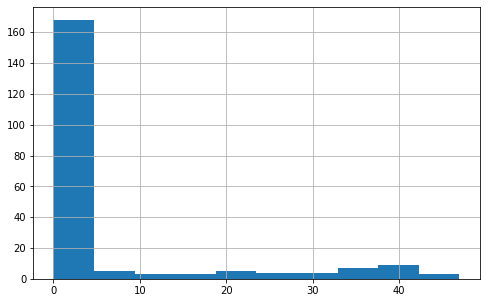

In [65]:
plt.figure(figsize=(8, 5))
ppg_yoy_pivot_df["ppg_last_sell_months"].hist()

<Axes: >

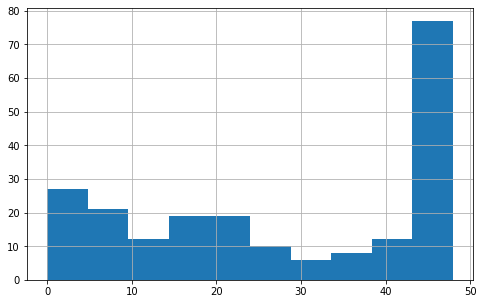

In [66]:
plt.figure(figsize=(8, 5))
ppg_yoy_pivot_df["ppg_life"].hist()

#### Lets write all these files in pickle

In [67]:
# volume_df,calendar_df,id_life_df,store_yoy_pivot_df,ppg_yoy_pivot_df

In [68]:
os.makedirs(os.path.join(os.getcwd(), processed_data_folder), exist_ok=True)

In [69]:
volume_df.to_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "volume_clean_daily.pkl")
)
calendar_df.to_pickle(os.path.join(os.getcwd(), processed_data_folder, "calendar.pkl"))
id_life_df.to_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "id_date_life.pkl")
)
store_yoy_pivot_df.to_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "poc_ranking.pkl")
)
ppg_yoy_pivot_df.to_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "ppg_ranking.pkl")
)

In [70]:
print(volume_df.shape)
print(calendar_df.shape)
print(id_life_df.shape)
print(store_yoy_pivot_df.shape)
print(ppg_yoy_pivot_df.shape)

(39779370, 10)
(1826, 23)
(1745002, 18)
(40574, 16)
(211, 16)


##### read the files for new cases

In [7]:
volume_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "volume_clean_daily.pkl")
)
calendar_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "calendar.pkl")
)
id_life_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "id_date_life.pkl")
)
store_yoy_pivot_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "poc_ranking.pkl")
)
ppg_yoy_pivot_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "ppg_ranking.pkl")
)

In [8]:
print(volume_df.shape)
print(calendar_df.shape)
print(id_life_df.shape)
print(store_yoy_pivot_df.shape)
print(ppg_yoy_pivot_df.shape)

(39779370, 10)
(1826, 23)
(1745002, 18)
(40574, 16)
(211, 16)


In [9]:
volume_df.head()

,poc_ppg_id,date,ppg_name,unique_poc_id,sales_volume_hl,adjusted_year,adjusted_month,week,year,month
0,AAAA__AK_AB_CG_T,2019-04-20,AK AB CG T,AAAA,0.065803,2019,4,16,2019,4
1,AAAA__AK_AB_CG_T,2019-05-25,AK AB CG T,AAAA,0.131605,2019,5,21,2019,5
2,AAAA__AK_CW_FM_CG_T,2020-06-13,AK CW FM CG T,AAAA,0.098704,2020,6,24,2020,6
3,AAAA__AR_EW_N_DS_CG_T,2019-02-11,AR EW N DS CG T,AAAA,0.000000,2019,2,7,2019,2
4,AAAA__AR_EW_N_DS_CG_T,2019-02-15,AR EW N DS CG T,AAAA,0.164507,2019,2,7,2019,2


In [10]:
calendar_df.head()

,date,year,month,week,adjusted_year,adjusted_month,year_week_start_date,day_of_the_week,is_weekend,is_month_start,is_month_end,quarter,key,holiday,month_sin_adj,month_cos_adj,month_sin,month_cos,week_sin,week_cos,quarter_sin,quarter_cos,year_month_start_date
0,2019-01-01,2019,1,1,2019,1,2019-01-01,1,0,1,0,1,1,1.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
1,2019-01-02,2019,1,1,2019,1,2019-01-01,2,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
2,2019-01-03,2019,1,1,2019,1,2019-01-01,3,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
3,2019-01-04,2019,1,1,2019,1,2019-01-01,4,1,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
4,2019-01-05,2019,1,1,2019,1,2019-01-01,5,1,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01


In [11]:
id_life_df.head()

,poc_ppg_id,unique_poc_id,ppg_name,start_date_vol,end_date_vol,unique_selling_days,year_week_start_date_id,year_month_start_date_id,date,life_from_start_months,last_selling_record_months,inactive_life,poc_last_sell_date,ppg_last_sell_date,poc_last_sell_months,ppg_last_sell_months,poc_life,ppg_life
0,AAAA__AK_AB_CG_T,AAAA,AK AB CG T,2019-04-20,2019-05-25,2,2019-04-15,2019-04-01,2019-04-20,44,43,0.98,2020-06-13,2022-12-31,30,0,16.657426,47.968131
1,AAAA__CJ_CZ_CG_EH,AAAA,CJ CZ CG EH,2019-04-20,2019-07-24,2,2019-04-15,2019-04-01,2019-04-20,44,41,0.93,2020-06-13,2022-12-31,30,0,16.657426,47.968131
2,AAAA__CM_CG_T,AAAA,CM CG T,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2020-06-13,2022-11-30,30,1,16.657426,46.949629
3,AACL__CJ_CZ_ES_ER,AACL,CJ CZ ES ER,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2022-12-24,2022-12-31,0,0,45.372595,47.968131
4,AACL__CJ_C_ES_ER,AACL,CJ C ES ER,2019-04-20,2019-04-20,1,2019-04-15,2019-04-01,2019-04-20,44,44,1.00,2022-12-24,2022-12-31,0,0,45.372595,47.968131


In [12]:
store_yoy_pivot_df.head()

,unique_poc_id,2019_agg_sales_stores,2020_agg_sales_stores,2021_agg_sales_stores,2022_agg_sales_stores,2020_store_pct_changes,2021_store_pct_changes,2022_store_pct_changes,2019_store_rank,2020_store_rank,2021_store_rank,2022_store_rank,median_rank,class_tier,poc_last_sell_months,poc_life
0,ATFX,143.105930,66.536801,223.515128,0.000000,-0.535052,2.359271,0.000000,4.0,6.0,1.0,40575.0,5.0,Top,20,26.809585
1,ADLZ,141.027655,57.514290,26.522603,77.540154,-0.592177,-0.538852,1.923550,5.0,8.0,84.0,5.0,6.5,Top,0,36.830325
2,ZE,77.938895,37.332118,62.715697,66.699363,-0.521008,0.679939,0.063519,7.0,23.0,10.0,9.0,9.5,Top,0,46.752500
3,ARSH,62.304890,54.196494,54.058244,49.117994,-0.130141,-0.002551,-0.091388,10.0,9.0,15.0,15.0,12.5,Top,0,47.836711
4,YUM,0.000000,80.608189,56.644129,56.663920,0.000000,-0.297291,0.000349,40575.0,4.0,14.0,11.0,12.5,Top,0,26.053923


In [13]:
ppg_yoy_pivot_df.head()

,ppg_name,2019_agg_sales_ppg,2020_agg_sales_ppg,2021_agg_sales_ppg,2022_agg_sales_ppg,2020_ppg_pct_changes,2021_ppg_pct_changes,2022_ppg_pct_changes,2019_ppg_rank,2020_ppg_rank,2021_ppg_rank,2022_ppg_rank,median_rank,class_tier,ppg_last_sell_months,ppg_life
0,DG CF AF CG EH,2.587642,4.594932,6.689961,6.652614,0.775722,0.455943,-0.005583,3.0,1.0,1.0,2.0,1.5,Top,0,47.968131
1,CJ CZ CG EH,2.156779,2.927878,3.791629,3.940741,0.357524,0.295009,0.039327,4.0,2.0,2.0,3.0,2.5,Top,0,47.968131
2,CJ C EN FE,1.847728,2.057525,2.254863,2.622337,0.113543,0.095911,0.162970,5.0,3.0,3.0,4.0,3.5,Top,0,47.968131
3,DG CF AF CG G,1.001200,1.383643,1.809349,2.473723,0.381985,0.307671,0.367190,13.0,6.0,4.0,5.0,5.5,Top,0,47.968131
4,CJ C CG T,1.130590,1.446797,1.589437,1.724798,0.279683,0.098591,0.085163,6.0,5.0,7.0,8.0,6.5,Top,0,47.968131


##### Volume aggregation at weekly

In [14]:
# this is to be used for continuity
volume_df_week_agg = volume_df.groupby(
    [
        "poc_ppg_id",
        "ppg_name",
        "unique_poc_id",
        "adjusted_year",
        "week",
    ],
    as_index=False,
).agg(sales_volume_hl_agg=("sales_volume_hl", "sum"))

In [15]:
volume_df_week_agg = volume_df_week_agg.sort_values(
    ["poc_ppg_id", "adjusted_year", "week"]
).reset_index(drop=True)

In [16]:
volume_df_week_agg.head()

,poc_ppg_id,ppg_name,unique_poc_id,adjusted_year,week,sales_volume_hl_agg
0,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,16,0.065803
1,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,21,0.131605
2,AAAA__AK_CW_FM_CG_T,AK CW FM CG T,AAAA,2020,24,0.098704
3,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,7,0.164507
4,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,16,0.098704


In [17]:
# volume_df_week_agg = reduce_mem_usage(volume_df_week_agg)

In [18]:
print(volume_df_week_agg.shape)
print(volume_df_week_agg.isnull().sum())

(37511978, 6)
poc_ppg_id             0
ppg_name               0
unique_poc_id          0
adjusted_year          0
week                   0
sales_volume_hl_agg    0
dtype: int64


In [19]:
# next we make the data continous at week level only

In [20]:
weekly_calendar_df = calendar_df.drop_duplicates(["week", "adjusted_year"])[
    ["week", "adjusted_year", "adjusted_month", "year_week_start_date", "key"]
].reset_index(drop=True)

In [21]:
weekly_calendar_df.head()

,week,adjusted_year,adjusted_month,year_week_start_date,key
0,1,2019,1,2019-01-01,1
1,2,2019,1,2019-01-07,1
2,3,2019,1,2019-01-14,1
3,4,2019,1,2019-01-21,1
4,5,2019,1,2019-01-28,1


In [22]:
weekly_calendar_df.shape

(261, 5)

In [23]:
id_life_df["key"] = 1

* we should put store and ppg filter delisting conditions over here
* Get the delisting lists from store and ppg 
* filter out those combinations from id_life_df

In [24]:
id_life_weekly_df = pd.merge(
    id_life_df[["poc_ppg_id", "year_week_start_date_id", "key"]].drop_duplicates(),
    weekly_calendar_df,
    on="key",
)

In [25]:
id_life_weekly_df.shape

(455445522, 7)

In [26]:
id_life_weekly_df.isnull().sum()

poc_ppg_id                 0
year_week_start_date_id    0
key                        0
week                       0
adjusted_year              0
adjusted_month             0
year_week_start_date       0
dtype: int64

In [27]:
# id_life_weekly_df.loc[id_life_weekly_df["poc_ppg_id"] == "AAAA__AK_AB_CG_T"]

In [28]:
# start from the actual starting date for each combinations
id_life_weekly_df = id_life_weekly_df.loc[
    id_life_weekly_df["year_week_start_date"]
    >= id_life_weekly_df["year_week_start_date_id"]
].reset_index(drop=True)

In [29]:
id_life_weekly_df = id_life_weekly_df.drop(["year_week_start_date_id", "key"], axis=1)

In [30]:
id_life_weekly_df.head()

,poc_ppg_id,week,adjusted_year,adjusted_month,year_week_start_date
0,AAAA__AK_AB_CG_T,16,2019,4,2019-04-15
1,AAAA__AK_AB_CG_T,17,2019,4,2019-04-22
2,AAAA__AK_AB_CG_T,18,2019,4,2019-04-29
3,AAAA__AK_AB_CG_T,19,2019,5,2019-05-06
4,AAAA__AK_AB_CG_T,20,2019,5,2019-05-13


In [31]:
# id_life_weekly_df.loc[id_life_weekly_df["poc_ppg_id"] == "AAAA__AK_AB_CG_T"]

In [32]:
id_life_weekly_df.shape

(340950155, 5)

In [33]:
# we merge this back to actual agg_volume df on the basis of poc_ppg_id week adjusted_year adjusted_month

In [34]:
volume_df_week_agg = pd.merge(
    volume_df_week_agg,
    id_life_weekly_df,
    on=["poc_ppg_id", "week", "adjusted_year"],
    how="outer",
)

In [35]:
volume_df_week_agg.head()

,poc_ppg_id,ppg_name,unique_poc_id,adjusted_year,week,sales_volume_hl_agg,adjusted_month,year_week_start_date
0,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,16,0.065803,4,2019-04-15
1,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,21,0.131605,5,2019-05-20
2,AAAA__AK_CW_FM_CG_T,AK CW FM CG T,AAAA,2020,24,0.098704,6,2020-06-08
3,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,7,0.164507,2,2019-02-11
4,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,16,0.098704,4,2019-04-15


In [36]:
volume_df_week_agg.isnull().sum()

poc_ppg_id                      0
ppg_name                303438177
unique_poc_id           303438177
adjusted_year                   0
week                            0
sales_volume_hl_agg     303438177
adjusted_month                  0
year_week_start_date            0
dtype: int64

In [37]:
volume_df_week_agg["sales_volume_hl_agg"] = volume_df_week_agg[
    "sales_volume_hl_agg"
].fillna(0.0)

In [38]:
# temp1 = (
#     volume_df_week_agg.groupby(["poc_ppg_id"], as_index=False)["sales_volume_hl_agg"]
#     .sum()
#     .sort_values(["sales_volume_hl_agg"], ascending=False)
# )

In [39]:
# temp_df = volume_df_week_agg.loc[
#     volume_df_week_agg["poc_ppg_id"].isin(
#         ["BJFR__DG_CF_AF_CG_EH", "AGEA__DG_CF_AF_CG_EH"]
#     )
# ].reset_index(drop=True)

In [40]:
# temp_df = temp_df.sort_values(["poc_ppg_id", "adjusted_year", "week"]).reset_index(
#     drop=True
# )

In [41]:
# temp_df[["ppg_name","unique_poc_id"]]= (temp_df.groupby(['poc_ppg_id'])[["ppg_name","unique_poc_id"]].
#                                         transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
#                                        )

In [42]:
# temp_df.isnull().sum()

In [43]:
volume_df_week_agg[["ppg_name","unique_poc_id"]] = (volume_df_week_agg.groupby(['poc_ppg_id'])[["ppg_name","unique_poc_id"]].
                                        transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
                                       )

In [44]:
# try with parallel apply faster 

In [45]:
volume_df_week_agg.isnull().sum()

poc_ppg_id              0
ppg_name                0
unique_poc_id           0
adjusted_year           0
week                    0
sales_volume_hl_agg     0
adjusted_month          0
year_week_start_date    0
dtype: int64

In [46]:
volume_df_week_agg.to_pickle(os.path.join(os.getcwd(), processed_data_folder,'volume_df_week_agg.pkl'))

##### Month Volume aggregates

In [47]:
# this is to be used for continuity
volume_df_month_agg = volume_df.groupby(
    [
        "poc_ppg_id",
        "ppg_name",
        "unique_poc_id",
        "year",
        "month",
    ],
    as_index=False,
).agg(sales_volume_hl_agg=("sales_volume_hl", "sum"))

In [48]:
volume_df_month_agg = volume_df_month_agg.sort_values(
    ["poc_ppg_id", "year", "month"]
).reset_index(drop=True)

In [49]:
volume_df_month_agg.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg
0,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,4,0.065803
1,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,5,0.131605
2,AAAA__AK_CW_FM_CG_T,AK CW FM CG T,AAAA,2020,6,0.098704
3,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,2,0.164507
4,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,4,0.098704


In [50]:
# volume_df_month_agg = reduce_mem_usage(volume_df_month_agg)

print(volume_df_month_agg.shape)
print(volume_df_month_agg.isnull().sum())

(19888426, 6)
poc_ppg_id             0
ppg_name               0
unique_poc_id          0
year                   0
month                  0
sales_volume_hl_agg    0
dtype: int64


In [51]:
# next we make the data continous at week level only
monthly_calendar_df = calendar_df.drop_duplicates(["month", "year"])[
    ["month", "year", "year_month_start_date", "key"]
].reset_index(drop=True)

In [52]:
monthly_calendar_df.head()

,month,year,year_month_start_date,key
0,1,2019,2019-01-01,1
1,2,2019,2019-02-01,1
2,3,2019,2019-03-01,1
3,4,2019,2019-04-01,1
4,5,2019,2019-05-01,1


In [53]:
monthly_calendar_df.shape

(60, 4)

In [54]:
id_life_df["key"] = 1

In [55]:
# * we should put store and ppg filter delisting conditions over here
# * Get the delisting lists from store and ppg 
# * filter out those combinations from id_life_df

In [56]:
id_life_monthly_df = pd.merge(
    id_life_df[["poc_ppg_id", "year_month_start_date_id", "key"]].drop_duplicates(),
    monthly_calendar_df,
    on="key",
)

In [57]:
id_life_monthly_df.shape

(104700120, 6)

In [58]:
id_life_monthly_df.isnull().sum()

poc_ppg_id                  0
year_month_start_date_id    0
key                         0
month                       0
year                        0
year_month_start_date       0
dtype: int64

In [59]:
# id_life_weekly_df.loc[id_life_weekly_df["poc_ppg_id"] == "AAAA__AK_AB_CG_T"]

# start from the actual starting date for each combinations
id_life_monthly_df = id_life_monthly_df.loc[
    id_life_monthly_df["year_month_start_date"]
    >= id_life_monthly_df["year_month_start_date_id"]
].reset_index(drop=True)

In [60]:
id_life_monthly_df = id_life_monthly_df.drop(["year_month_start_date_id", "key"], axis=1)

In [61]:
id_life_monthly_df.head()

,poc_ppg_id,month,year,year_month_start_date
0,AAAA__AK_AB_CG_T,4,2019,2019-04-01
1,AAAA__AK_AB_CG_T,5,2019,2019-05-01
2,AAAA__AK_AB_CG_T,6,2019,2019-06-01
3,AAAA__AK_AB_CG_T,7,2019,2019-07-01
4,AAAA__AK_AB_CG_T,8,2019,2019-08-01


In [62]:
# id_life_weekly_df.loc[id_life_weekly_df["poc_ppg_id"] == "AAAA__AK_AB_CG_T"]

id_life_monthly_df.shape

(79049668, 4)

In [63]:
# we merge this back to actual agg_volume df on the basis of poc_ppg_id week adjusted_year adjusted_month

volume_df_month_agg = pd.merge(
    volume_df_month_agg,
    id_life_monthly_df,
    on=["poc_ppg_id", "month", "year"],
    how="outer",
)

In [64]:
volume_df_month_agg.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date
0,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,4,0.065803,2019-04-01
1,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,5,0.131605,2019-05-01
2,AAAA__AK_CW_FM_CG_T,AK CW FM CG T,AAAA,2020,6,0.098704,2020-06-01
3,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,2,0.164507,2019-02-01
4,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,4,0.098704,2019-04-01


In [65]:
volume_df_month_agg.shape

(79049668, 7)

In [66]:
volume_df_month_agg.isnull().sum()

poc_ppg_id                      0
ppg_name                 59161242
unique_poc_id            59161242
year                            0
month                           0
sales_volume_hl_agg      59161242
year_month_start_date           0
dtype: int64

In [67]:
volume_df_month_agg["sales_volume_hl_agg"] = volume_df_month_agg[
    "sales_volume_hl_agg"
].fillna(0.0)

In [68]:
volume_df_month_agg[["ppg_name","unique_poc_id"]] = (volume_df_month_agg.groupby(['poc_ppg_id'])[["ppg_name","unique_poc_id"]].
                                        transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
                                       )

In [69]:
# try by splitting with parallel apply faster 
volume_df_month_agg.isnull().sum()

poc_ppg_id               0
ppg_name                 0
unique_poc_id            0
year                     0
month                    0
sales_volume_hl_agg      0
year_month_start_date    0
dtype: int64

In [70]:
volume_df_month_agg.to_pickle(os.path.join(os.getcwd(), processed_data_folder,'volume_df_month_agg.pkl'))

In [71]:
ls_m = volume_df_month_agg["sales_volume_hl_agg"].tolist()

In [72]:
ls_w = volume_df_week_agg["sales_volume_hl_agg"].tolist()

In [73]:
ls1 = volume_df["sales_volume_hl"].tolist()

In [74]:
sum(ls_m)

45147700.85486216

In [75]:
sum(ls_w)

45147700.854487136

In [76]:
sum(ls1)

45147700.85447763

#### Next todo -in this script
fill miising poc id with NA1

#### Suraj
- Identify Delisted poc -> poc_ranking
- Identify Delisted ppg -> ppg_ranking
- Clean and remove dups POC attribute and PPG attributes
- poc_ranking -> remove delisted poc and add poc feats
- ppg ranking -> remove delisted ppg and add ppg feats
- save the delisted list for both as pickle